# It's a Start

### Imports

In [36]:
import simpy
import itertools
import numpy as np
import matplotlib.pyplot as plt

### Creative liberties

*Insert explanation of arrival rate and closing time.

The café is open for 9 hours, say 6:30 to 15:30, with a rush hour around 08:30. As a baseline the café gets around 4 customers per hour, but during rush hours this jumps to 20.

In [ ]:
CLOSING_TIME = 540 # The café is open for 9 hours.

def arrival_rate(time):
    '''
    Arrival rate in customers per --> minute <--.
    Should peak at around 120 minutes in, that's 08:30.

    arrival_rate(t) = baseline + ( peak * gaussian_bump(t) )
    '''

    baseline    = 10/60     # 10 customers per hour as the baseline.
    peak        = 50/60     # 50 customers per hour at peak hours.
    rush        = 120       # That's 120 minutes into the day. 08:30 if we started at 06:30.
    rush_length = 60        # Length of rush hour (1 hour).

    return (baseline +   (peak *   (np.exp(-((time-rush)**2) / (2*(rush_length**2))))   )   )

Additionally, there are some variables which should be hard-coded in the system. For example, the chance that a coffee machine needs to be utilized in order to complete an order could be something like 90%. In the same vein, the likelihood that an oven needs to be used to complete an order (to heat up a cinnamon bun, or something like that) could be 15%.

There's always a small chance of these machines breaking down, in which case fixing them would take some time. We can assume that a person will be called to repair the machine as soon as it does break dow. (*say something about the distribution of how long a repair should take. The person must travel there and then actually repair it.)

Notably, we're normalizing everything to SimPy time units = minutes. For the sake of avoiding confusion and ensuring consistency, we will wisely also define seconds, minutes and hours in this context.

* Note that every function that returns a duration should return said value in *minutes*.

The "default variables" will also be defined here. That is:

| Number | Resource | Explanation |
| ------ | -------- | ----------- |
| 1 | Register | Order-takers. |
| 2 | Barista | Order-preparers. |
| 1 | Pickup station | Where customers pick up their orders. |
| 2 | Coffee Machine | The baristas take turn using the coffee machines. |
| 1 | Oven | The baristas take turns using the ovens. |

* We'll also want to add a schedule and whatnot in here, I assume.

These are global variables.

In [ ]:
SECONDS = 1/60
MINUTES = 1
HOURS = 60

CHANCE_THAT_COFFEE_MACHINE_NEEDED = 0.9
CHANCE_THAT_OVEN_NEEDED = 0.15

DEFAULT_NUM_REGISTERS       = 1
DEFAULT_NUM_BARISTAS        = 2 
DEFAULT_NUM_PICKUP_STATIONS = 1 
DEFAULT_NUM_COFFEE_MACHINES = 2 
DEFAULT_NUM_OVENS           = 1 

### Metrics that I'm going to keep track of: a checklist.

1) How long customers have to wait, from when they arrive at the café to when they pick up their order.
    - Would also be nice to see how long customers wait in each "act" (waiting to order + ordering, waiting for their order, picking up their order).  
2) How well all resources are utilized (employees in particular), how much idle time they have.

In [ ]:
class Stats:
    '''A class to keep track of the numbers for each simulation.'''

    def __init__(self):
        # CUSTOMER TIME-TRACKING
        self.register_queue_time = []           # Time each customer spent waiting to place their order.
        self.pickup_queue_time = []             # Time each custimer spent picking up their order.
        self.total_time_in_system = []          # Total time each customer spent from arrival time to pickup time.
        
        self.time_until_prep_begins = []        # The time from the customer places the order until a barista begins working on it.

        self.arrival_times = []                 # For plotting.

        # OTHER CUSTOMER-RELATED MEASURES
        self.avg_length_register_queue = []     # This is a list because we might also want to graph this. Average length of queue per every hour, or something.
        self.avg_length_pickup_queue = []       # I don't think this has ever not been 0. I'm tracking it for the sake of consistency, though.
        self.avg_count_customers_waiting = []   # Could also be cool to graph.

        # TODO: RESOURCE UTILIZATION


### Time distributions defined

*Needs revision

Note that these should all return the time in minutes.

In [40]:
# Once again, we have yet to pin down the service time distribution,
# but to start implementing I'll just assume that it takes at least 5 seconds
# and that the mean is 45 seconds with a standard deviation of 10. Or something.
def order_time(rng):
    '''How long it takes a customer to order, in minutes.'''
    return max(5, rng.normal(45, 10)) * SECONDS


# ... it's gotta take at least 5 seconds, that's if you're just taking out a croissant and putting it on a dish or something.
# I'll just take a wild guess of 3 minutes (180 seconds) as the mean and 20 seconds as the standard deviation.
# Also I added the time it takes to pay. 
def making_order_time(rng):
    '''How long it takes to get the order ready.
    TODO: We might want to change this process later, add coffe machines and such as resources, and so on.
    For now though, it's just a distribution like so.'''

    #       Time taken to order             Time taken to pay
    return (max(10, rng.normal(180, 20)) + max(3, rng.normal(7, 3))) * SECONDS


# It's gotta take at least a second.
# I'm just going to be optimistic and guess that the mean is 5 seconds, and the std is 1.
def pickup_time(rng):
    '''How long it takes the customer to pick up the order.'''
    return max(1, rng.normal(5, 1)) * SECONDS


# Uniform distribution, minimum 0.5 minutes and maximum 2 minutes.
def coffee_machine_time(rng):
    '''How long it takes the barista to use the coffee machine for a given order.'''
    return rng.uniform(low=30, high=120) * SECONDS


# Uniform distribution, minimum 1 minute maximum 5 minutes (just to heat things up).
def oven_time(rng):
    '''How long it takes the barista to use the oven for a given order.'''
    return rng.uniform(low=60, high=300) * SECONDS

### Helpers

In [ ]:
def use_coffee_machine(env, ID, coffee_machine, rng):
    '''If a barista needs to use a coffee machine, this function will run.'''

    with (coffee_machine.request() as req):
        yield req
        time = coffee_machine_time(rng)
        print(f"{ID} using coffee machine for {time:.2f} seconds at {env.now:.2f}.")
        yield env.timeout(time)

def use_oven(env, ID, oven, rng):
    '''If a barista needs to use an oven, this function will run.'''

    with (oven.request() as req):
        yield req
        time = oven_time(rng)
        print(f"{ID} using oven for {time:.2f} seconds at {env.now:.2f}.")
        yield env.timeout(time)

In [ ]:
def print_stats(statistics):
    '''The stats for each simulation run on a printed format.'''

    print("Total times in register queue:\n", statistics.register_queue_time)
    print("Time from when the order is placed until a barista begins working on it:\n", statistics.time_until_prep_begins)
    print("Total times in pickup queue:\n", statistics.pickup_queue_time)
    print("Total times in system:\n", statistics.total_time_in_system)
    # *More.

def plot_stats(statistics):
    '''To avoid repeating ourselves.'''

    plt.plot(statistics.total_time_in_system)
    plt.ylabel('Waiting time for customers 0 to i')
    plt.show()
    
    plt.plot(statistics.register_queue_time)
    plt.ylabel('Waiting time in register queue for customers 0 to i')
    plt.show()
    
    plt.plot(statistics.pickup_queue_time)
    plt.ylabel('Waiting time in pickup queue for customers 0 to i')
    plt.show()
    
    plt.plot(statistics.time_until_prep_begins)
    plt.ylabel('Waiting time until barista begins working on order for customers 0 to i')
    plt.show()

def plot_arrivals(statistics):
    '''Plots arrivals as a scatter plot + rate histogram.'''

    arrivals = statistics.arrival_times
    
    plt.figure(figsize=(10,4))

    # Scatter plot:
    plt.scatter(arrivals, [0]*len(arrivals), s=10)
    plt.title("Arrivals Scatter Plot")
    plt.xlabel("Time (minutes)")
    plt.yticks([])
    plt.show()

    # Histogram:
    plt.figure(figsize=(10,4))
    plt.hist(arrivals, bins=30)
    plt.xlabel("Time (minutes)")
    plt.ylabel("# Arrivals")
    plt.title("Arrivals Histogram")
    plt.show()


### Meatier functions

In [ ]:

def customer(env, stats_keeper, ID, register, barista, pickup, coffee_machine, oven, rng):
    '''
    Customer's "lifecycle".
    A customer arrives to wait in line, orders + pays, waits while a barista prepares their order, and then pick up their order when it's ready.
    
    Note that the baristas may also use resources such a coffee machine or oven, and the availability of such devices affects the customer's waiting time.
    
    Params:
        - env:              simpy.Environment.  The environment of this current run.
        - stats_keeper:     Stats.              Used for collecting stats on the simulation run.
        - ID:               Int.                The customer's ID.
        - register:         Resource.           Staff member who takes your order.
        - barista:          Resource.           Staff member who makes your order.
        - pickup:           Resource.           The spot where you pick up your drink.
        - coffee_machine:   Resource.           The baristas likely need to use it to prepare your order.
        - oven:             Resource.           The baristas may need to use it to prepare your order.
        - rng:              Generator.          A random number generator (RNG).
    '''

    arrival = env.now
    print(f'{ID} arrives at {arrival:.2f}')

    # TODO: I could refactor these "acts" into different function. For readibility. 

    # # # # # # # # # # # # # # 
    #   ACT I: The Register   #
    # # # # # # # # # # # # # # 
    with (register.request() as req):
        yield req # Waiting in line.

        start_ordering = env.now

        print(f"{ID} begins ordering at {start_ordering:.2f}")

        # We wait while the customer places their order.
        ordering = order_time(rng)
        yield env.timeout(ordering)

        stop_ordering = env.now
        print(f"{ID} finishes ordering at {stop_ordering:.2f}")

    # # # # # # # # # # # # # # 
    #   ACT II: The Waiting   #
    # # # # # # # # # # # # # # 
    # The barista may need to #
    # use the coffee machine  #
    # and/or oven to complete #
    # the order, and on top   #
    # of that some time gets  #
    # added.                  #
    # # # # # # # # # # # # # # 
    with (barista.request() as req):
        yield req

        prep_begin = env.now
        print(f"{ID}'s order preperation begins at {prep_begin:.2f}")

        # The time it takes to get an order ready is:
        #
        #       time using coffee machine   Distribution: Uniform
        #   +   time using oven             Distribution: Uniform
        #   +   general prep time           Distribution: Triangle
        #   =   total time                  Distribution: Looks a bit sillier

        needs_coffee =  rng.random() < CHANCE_THAT_COFFEE_MACHINE_NEEDED
        needs_oven =    rng.random() < CHANCE_THAT_OVEN_NEEDED
        if (needs_coffee):
            use_coffee_machine(env, ID, coffee_machine, rng)
        if (needs_oven):
            use_oven(env, ID, oven, rng)

        prep_time = making_order_time(rng)
        yield env.timeout(prep_time)

        # - - - - - - - - - - Order finished! - - - - - - - - - -

        time_ready = env.now
        print(f"{ID}'s is ready for pickup at {time_ready:.2f}")


    # # # # # # # # # # # # # # 
    #   ACT III: The Pickup   #
    # # # # # # # # # # # # # #
    with pickup.request() as req:
        yield req

        start_pickup = env.now
        print(f"{ID} goes to pick up their order at {start_pickup:.2f}")

        pickupp_time = pickup_time(rng)
        yield env.timeout(pickupp_time)

        end_time = env.now
        print(f"{ID} leaves at {end_time:.2f}")

    # # # # # # # # # # # # # # #
    #   ALSO: Gathering Stats   #
    # # # # # # # # # # # # # # #

    time_in_register_queue = (start_ordering - arrival)
    time_in_pickup_queue = (time_ready - start_pickup)
    total_time = end_time - arrival
    stats_keeper.register_queue_time.append(time_in_register_queue)  # TODO: Do we maybe want :.2f?
    stats_keeper.pickup_queue_time.append(time_in_pickup_queue)
    stats_keeper.total_time_in_system.append(total_time)

    time_from_order_to_prep_start = time_ready - prep_begin
    stats_keeper.time_until_prep_begins.append(time_from_order_to_prep_start)


In [ ]:

def arrivals_generator(env, stats_keeper, register, barista, pickup, coffee_machine, oven, arrival_rate, closing_time, seed=None):
    '''
    Generates arrivals of customers according to the chosen arrival_rate.
    Runs the 'customer' process for each of the arrivals.

    Params:
        - env:              simpy.Environment.  The environment of this current run.
        - stats_keeper:     Stats.              Used for collecting stats on the simulation run.
        - register:         Resource.           Staff member who takes your order.
        - barista:          Resource.           Staff member who makes your order.
        - pickup:           Resource.           The spot where you pick up your drink.
        - coffee_machine:   Resource.           The baristas likely need to use it to prepare your order.
        - oven:             Resource.           The baristas may need to use it to prepare your order.
        - arrival_rate:     A function.         Returns the "customers per minute" arrival rate based on the the current time.
        - closing_time:     Int.                At which time the staff will stop serving new customers.
        - seed:             int.                Seed for a random number generator.
    '''

    rng = np.random.default_rng(seed)

    customer_ID = 0
    inter_arrival = 0
    while True:

        if ((env.now + inter_arrival) >= closing_time):
            print(f"\nCLOSING SHOP. \nNo more arrivals after closing at {closing_time:.2f}.\n")
            return

        rate = arrival_rate(env.now)

        inter_arrival = rng.exponential(1 / rate)       # Inter arrival from exponential dist.
        yield env.timeout(inter_arrival)                # Waiting until the next arrival.

        arrival_time = env.now                          # For plotting.
        stats_keeper.arrival_times.append(arrival_time)

        env.process(customer(
            env, 
            stats_keeper,
            customer_ID, 
            register, 
            barista,
            pickup,
            coffee_machine,
            oven,
            rng
        ))
        customer_ID += 1

I should probably add a short description above each function. Readibility reasons.

In [ ]:
def simulate(num_registers, num_baristas, num_pickups, num_coffee_machines, num_ovens, arrival_rate, closing_time, ttl):
    '''
    Simulates the process with the specified:
        - num_registers:        Int.    Number of registers / staff at registers.
        - num_baristas:         Int.    Number of baristas (those preparing orders).
        - num_pickups:          Int.    Number of places where drinks can be picked up.
        - num_coffee_machines:  Int.    Number of coffee machines which baristas have at their disposal.
        - num_coffee_ovens:     Int.    Number of ovens which baristas have at their disposal.
        - rates:                Dict.   the customers-per-hour rate for each period of time.
        - closing_time:         Int.    this is when new customers should stop coming in. This is just when we stop taking orders.
        - ttl:                  Float.  "time-to-live", how long the simulation will be allowed to run (in case there are some customers still awaiting their orders).

    Returns:
        - statistics:           Stats. The numbers for this particular simulation run.
    '''
    
    env = simpy.Environment()
    statistics = Stats()

    register = simpy.Resource(env, capacity=num_registers)      # Note: SimPy resources are FIFO by default.
    barista = simpy.Resource(env, capacity=num_baristas)        # We have [CAPACITY] amount of baristas, each can focus on one order at a time.
    pickup = simpy.Resource(env, capacity=num_pickups)
    coffee_machine = simpy.Resource(env, capacity=num_coffee_machines)
    oven = simpy.Resource(env, capacity=num_ovens)

    env.process(arrivals_generator(
        env=env, 
        stats_keeper=statistics,
        register=register, 
        barista=barista,
        pickup=pickup,
        coffee_machine=coffee_machine,
        oven=oven,
        arrival_rate=arrival_rate,
        closing_time=CLOSING_TIME,
        seed=360
    ))
    env.run(until=ttl)  # TODO: NOTE: way beyond closing time. I just wanted to see how much would be done in this time. People stop coming in after closing.

    return statistics


## Default run, default values

In [ ]:
default = simulate(
    num_registers=DEFAULT_NUM_REGISTERS, 
    num_baristas=2,
    num_pickups=1, 
    num_coffee_machines=2,
    num_ovens=1,
    arrival_rate=arrival_rate, 
    closing_time=CLOSING_TIME, 
    ttl=1000)

0 arrives at 1.73
0 begins ordering at 1.73
0 finishes ordering at 2.43
0's order preperation begins at 2.43
0's is ready for pickup at 5.51
0 goes to pick up their order at 5.51
0 leaves at 5.58
1 arrives at 6.26
1 begins ordering at 6.26
1 finishes ordering at 7.04
1's order preperation begins at 7.04
2 arrives at 9.24
2 begins ordering at 9.24
1's is ready for pickup at 10.05
1 goes to pick up their order at 10.05
1 leaves at 10.11
3 arrives at 10.19
2 finishes ordering at 10.22
2's order preperation begins at 10.22
3 begins ordering at 10.22
3 finishes ordering at 10.68
3's order preperation begins at 10.68
2's is ready for pickup at 12.59
2 goes to pick up their order at 12.59
2 leaves at 12.67
3's is ready for pickup at 13.37
3 goes to pick up their order at 13.37
3 leaves at 13.41
4 arrives at 13.48
4 begins ordering at 13.48
4 finishes ordering at 14.15
4's order preperation begins at 14.15
4's is ready for pickup at 17.32
4 goes to pick up their order at 17.32
4 leaves at 17.4

#### Stats Display

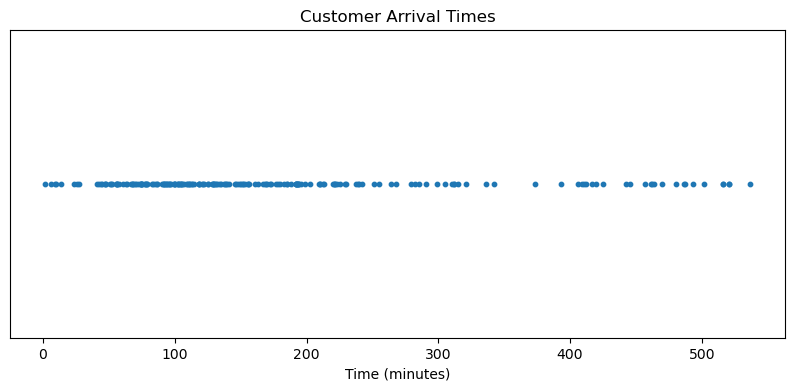

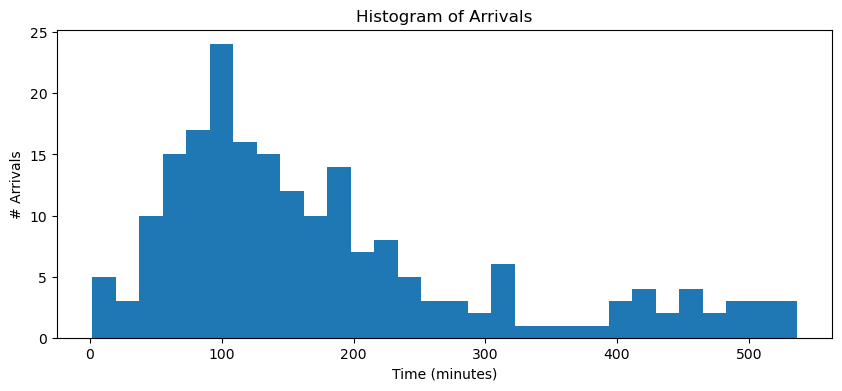

Total times in register queue:
 [0.0, 0.0, 0.0, 0.0303776772725719, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.3088006240771435, 0.31374679329425703, 0.0, 0.6043281151858224, 0.0, 0.0, 0.0, 0.0, 0.0, 1.3713121925947007, 0.8943513543766457, 0.5463252215003962, 0.0, 0.0, 0.018996675715499123, 0.0, 0.1231875180363744, 0.014719988229899172, 0.7421562298951159, 0.21460257324483223, 0.0, 0.0, 0.0, 0.561002855309539, 1.1502645271778675, 1.928896835143746, 1.7948585887085216, 2.6223584641601576, 1.1686051194522094, 1.6931699023465256, 1.972301107688466, 1.867129298200723, 2.1247999694199535, 0.0, 0.08377151077399958, 0.0, 0.46236859817922493, 0.0, 0.0, 0.3866224833600569, 0.6715333029951438, 0.8911060984274144, 1.5691304050071864, 1.6602667527081962, 0.7385203905984525, 1.5036513159439124, 1.247991509785166, 1.850841327217708, 2.171394892176707, 2.064168264567286, 0.9416504659494507, 1.4217423621046663, 1.8652043766293218, 1.2174640615540113, 1.8055505956585876, 1.1253730734647576, 2.638085584605321

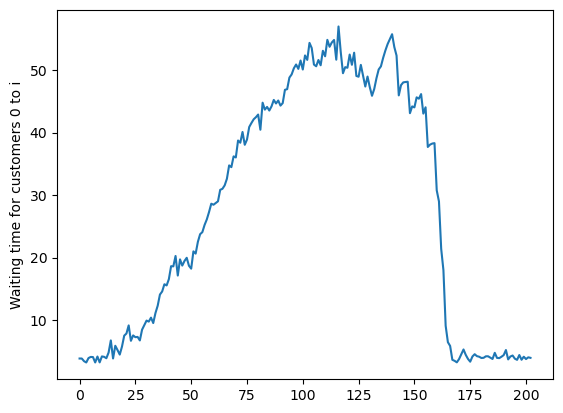

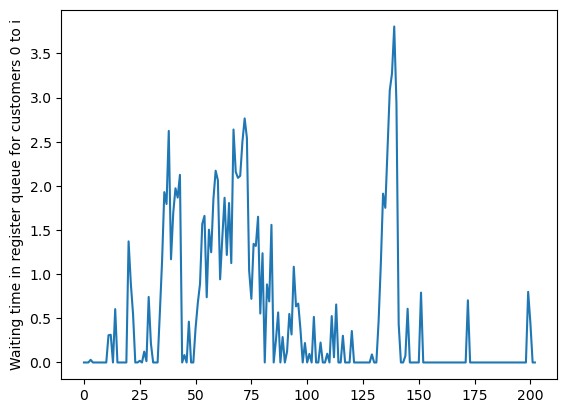

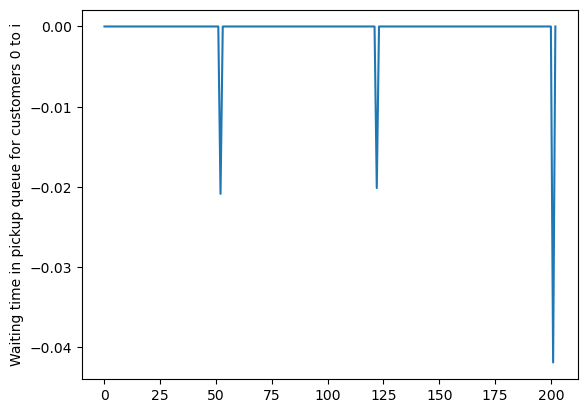

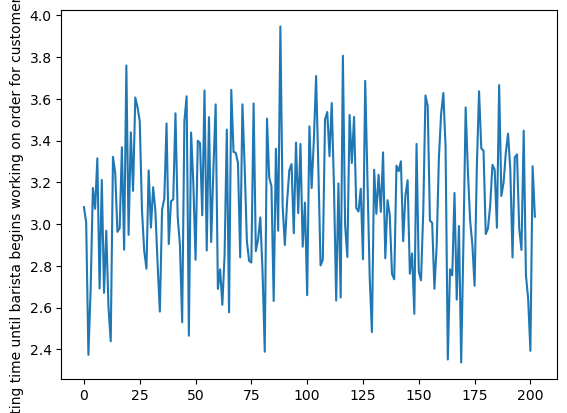

In [47]:
plot_arrivals(default)
print_stats(default)
plot_stats(default)

## Experiments

An experiment can be given on the following format:

In [48]:
class Experiment:
    '''A class  representing a single experiment.'''

    def __init__(self):
        self.num_of_simulations = 1 # One simulation is run by default.
        self.num_registers = DEFAULT_NUM_REGISTERS
        self.num_baristas = DEFAULT_NUM_BARISTAS
        self.num_pickups = DEFAULT_NUM_PICKUP_STATIONS
        self.num_coffee_machines = DEFAULT_NUM_COFFEE_MACHINES
        self.num_ovens = DEFAULT_NUM_OVENS

        # TODO: We'll add more as we add schedules and such.